In [1]:
# ======================================================
# INSTALACIÓN DE LIBRERÍAS ADICIONALES (solo Colab)
# ======================================================
# Instalamos imbalanced-learn (balanceo de clases) y kagglehub (descarga directa de Kaggle)
!pip install -q imbalanced-learn
!pip install -q kagglehub

In [3]:
# ============================================================
# IMPORTACIÓN DE LIBRERÍAS NECESARIAS
# ============================================================

# ---- Manipulación de datos ----
import pandas as pd
import numpy as np

# ---- Visualización ----
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Utilidades para Google Colab (descarga Kaggle, manejo de archivos) ----
import kagglehub
from pathlib import Path

# ---- Machine Learning: modelos y procesamiento ----
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# ---- Métricas y evaluación ----
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)

# ---- Balanceo de clases ----
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek, SMOTEENN

# ---- Serialización de modelos y otros ----
import joblib

# ---- Otros ----
import warnings
warnings.filterwarnings('ignore')

In [4]:
# ============================================================
# DESCARGA Y CARGA DEL DATASET DE FRAUDE DE TARJETAS DE CRÉDITO
# ============================================================

# Descargar el dataset de Kaggle usando kagglehub
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

# Mostrar la ruta donde se descargaron los archivos del dataset
print("Path to dataset files:", path)

# Ruta al archivo CSV principal del dataset
csv_file_path = path + '/creditcard.csv'

# Cargar el archivo CSV en un DataFrame de pandas
df_model = pd.read_csv(csv_file_path)

# Mostrar las primeras 5 filas para inspeccionar los datos cargados
df_model.head()

Path to dataset files: /kaggle/input/creditcardfraud


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
# ============================================================
# COPIA DEL DATAFRAME PARA EL PIPELINE DE MODELADO
# ============================================================

# Crear una copia del DataFrame original para evitar modificar los datos crudos durante el preprocesamiento y modelado
df = df_model.copy()

In [6]:
# ==================================================================
# CLASE UTILITARIA PRA ANALISIS Y CLASIFICACIÓN: FastFraudClassifier
# ==================================================================

class FastFraudClassifier:
    """
    Clasificador optimizado para Google Colab - Entrenamiento rápido
    """

    def __init__(self):
        # Inicializa estructuras para modelos y escalador
        self.models = {}
        self.scaler = StandardScaler()
        self.best_model = None
        self.best_model_name = None

    def load_data(self, file_path='creditcard.csv'):
        """
        Carga el dataset (desde archivo local o URL de Kaggle)
        """
        print("🔍 Cargando datos...")

        try:
            # Carga los datos desde la ruta local especificada
            self.df = pd.read_csv(csv_file_path)
        except FileNotFoundError:
            # Mensaje de error y recomendaciones si el archivo no se encuentra
            print("📁 Archivo no encontrado localmente.")
            print("💡 Sugerencia: Sube el archivo creditcard.csv a Colab o usa Kaggle API")
            print("   Para usar Kaggle API:")
            print("   !pip install kaggle")
            print("   !kaggle datasets download -d mlg-ulb/creditcardfraud")
            return None

        # Resumen del dataset y distribución de clases
        print(f"✅ Dataset cargado: {self.df.shape}")
        print(f"📊 Distribución de clases:")
        class_dist = self.df['Class'].value_counts()
        print(f"   Legítimas: {class_dist[0]} ({class_dist[0]/len(self.df)*100:.2f}%)")
        print(f"   Fraudulentas: {class_dist[1]} ({class_dist[1]/len(self.df)*100:.2f}%)")

        return self.df

    def quick_eda(self):
        """
        Análisis exploratorio rápido y visualización
        """
        print("\n📊 Análisis Exploratorio Rápido...")

        # Estadísticas básicas y valores nulos
        print(f"Valores nulos: {self.df.isnull().sum().sum()}")
        print(f"Monto promedio (legítimas): ${self.df[self.df['Class']==0]['Amount'].mean():.2f}")
        print(f"Monto promedio (fraudes): ${self.df[self.df['Class']==1]['Amount'].mean():.2f}")

        # Visualizaciones: clases, montos y correlaciones
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        self.df['Class'].value_counts().plot(kind='bar', ax=axes[0], color=['skyblue', 'salmon'])
        axes[0].set_title('Distribución de Clases')
        axes[0].set_xlabel('Clase')
        axes[0].set_ylabel('Cantidad')
        axes[0].tick_params(axis='x', rotation=0)

        axes[1].hist(self.df[self.df['Class']==0]['Amount'], bins=30, alpha=0.7,
                    label='Legítima', color='skyblue', density=True)
        axes[1].hist(self.df[self.df['Class']==1]['Amount'], bins=30, alpha=0.7,
                    label='Fraude', color='salmon', density=True)
        axes[1].set_xlabel('Monto')
        axes[1].set_ylabel('Densidad')
        axes[1].set_title('Distribución de Montos')
        axes[1].legend()
        axes[1].set_xlim(0, 1000)

        correlations = self.df.corr()['Class'].sort_values(key=abs, ascending=False)[1:8]
        correlations.plot(kind='barh', ax=axes[2], color='lightcoral')
        axes[2].set_title('Top Correlaciones con Fraude')
        axes[2].set_xlabel('Correlación')

        plt.tight_layout()
        plt.show()

    def prepare_data_fast(self, sample_size=50000, test_size=0.2):
        """
        Preparación rápida de datos con muestreo para acelerar entrenamiento
        """
        print(f"\n🔧 Preparando datos (muestra de {sample_size:,} registros)...")

        # Muestreo estratificado para acelerar el entrenamiento
        if len(self.df) > sample_size:
            # Incluye todos los fraudes y una muestra de legítimas
            fraud_data = self.df[self.df['Class'] == 1]
            legit_data = self.df[self.df['Class'] == 0].sample(
                n=sample_size - len(fraud_data), random_state=33
            )
            self.df_sample = pd.concat([fraud_data, legit_data]).sample(frac=1, random_state=33)
            print(f"📊 Muestra creada: {len(self.df_sample):,} registros")
            print(f"   Fraudes: {len(fraud_data):,}, Legítimas: {len(legit_data):,}")
        else:
            self.df_sample = self.df.copy()

        # Separar variables predictoras y objetivo (sin 'Time')
        X = self.df_sample.drop(['Time', 'Class'], axis=1)
        y = self.df_sample['Class']

        # División estratificada train/test
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=test_size, random_state=33, stratify=y
        )

        print(f"✅ División completada:")
        print(f"   Entrenamiento: {self.X_train.shape[0]:,} muestras")
        print(f"   Prueba: {self.X_test.shape[0]:,} muestras")

        # Guardar el orden de las variables para uso posterior
        self.feature_order = self.X_train.columns.tolist()

        return self.X_train, self.X_test, self.y_train, self.y_test

    def train_fast_models(self):
        """
        Entrenamiento rápido con modelos seleccionados y parámetros optimizados
        """
        print("\n🚀 Entrenamiento rápido de modelos...")

        # Configuración de modelos para entrenamiento ágil
        models_config = {
            'LogisticRegression': {
                'model': LogisticRegression(random_state=33, max_iter=500, solver='liblinear'),
                'fast': True
            },
            'RandomForest_Fast': {
                'model': RandomForestClassifier(
                    n_estimators=50,
                    max_depth=10,
                    random_state=33,
                    n_jobs=-1,
                    min_samples_split=10
                ),
                'fast': True
            }
        }

        # Estrategias rápidas de balanceo de clases
        balancing_strategies = {
            'Original': None,
            'SMOTE_Fast': SMOTE(random_state=33, k_neighbors=3),
            'UnderSample': RandomUnderSampler(random_state=33)
        }

        results = {}

        for model_name, model_config in models_config.items():
            for balance_name, balancer in balancing_strategies.items():
                print(f"⚡ {model_name} + {balance_name}...", end=' ')

                # Copiar datos para evitar efectos colaterales
                X_train_bal, y_train_bal = self.X_train.copy(), self.y_train.copy()

                # Escalar solo la variable 'Amount'
                X_train_scaled = X_train_bal.copy()
                X_test_scaled  = self.X_test.copy()
                self.scaler.fit(X_train_bal[["Amount"]])
                X_train_scaled["Amount"] = self.scaler.transform(X_train_bal[["Amount"]])
                X_test_scaled["Amount"]  = self.scaler.transform(self.X_test[["Amount"]])

                # Aplicar balanceo de clases si corresponde
                if balancer is not None:
                    X_train_scaled, y_train_bal = balancer.fit_resample(X_train_scaled, y_train_bal)

                # Entrenamiento del modelo
                model = model_config['model']
                model.fit(X_train_scaled, y_train_bal)

                # Predicciones y métricas principales
                y_pred = model.predict(X_test_scaled)
                y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
                auc_score = roc_auc_score(self.y_test, y_pred_proba)
                avg_precision = average_precision_score(self.y_test, y_pred_proba)

                # Guarda resultados de cada configuración
                model_key = f"{model_name}_{balance_name}"
                self.models[model_key] = {
                    'model': model,
                    'scaler': self.scaler
                }
                results[model_key] = {
                    'auc_score': auc_score,
                    'avg_precision': avg_precision,
                    'predictions': y_pred,
                    'probabilities': y_pred_proba
                }

                print(f"AUC: {auc_score:.4f} | AP: {avg_precision:.4f}")

        self.results = results
        return results

    def select_and_evaluate_best(self):
        """
        Selección y evaluación del mejor modelo
        """
        print("\n🏆 Selección del mejor modelo:")
        print("-" * 60)

        # Buscar el modelo con mejor AUC
        best_auc = 0
        best_model_key = None
        for model_key, metrics in self.results.items():
            auc = metrics['auc_score']
            ap = metrics['avg_precision']
            print(f"{model_key:<25} AUC: {auc:.4f} | AP: {ap:.4f}")
            if auc > best_auc:
                best_auc = auc
                best_model_key = model_key

        print("-" * 60)
        print(f"🎯 Mejor modelo: {best_model_key} (AUC: {best_auc:.4f})")

        # Asigna el mejor modelo encontrado
        self.best_model = self.models[best_model_key]
        self.best_model_name = best_model_key

        # Evaluación y reporte de desempeño
        print(f"\n📊 Evaluación detallada:")
        y_pred = self.results[best_model_key]['predictions']
        y_pred_proba = self.results[best_model_key]['probabilities']

        print("\n📋 Reporte de Clasificación:")
        print(classification_report(self.y_test, y_pred, target_names=['Legítima', 'Fraude']))

        cm = confusion_matrix(self.y_test, y_pred)
        print(f"\n🔍 Matriz de Confusión:")
        print(f"              Predicho")
        print(f"           Legít. Fraude")
        print(f"Real Legít.  {cm[0,0]:4d}   {cm[0,1]:4d}")
        print(f"Real Fraude  {cm[1,0]:4d}   {cm[1,1]:4d}")

        # Cálculo de métricas principales
        tn, fp, fn, tp = cm.ravel()
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        print(f"\n📈 Métricas Clave:")
        print(f"   Precision: {precision:.4f} (de los predichos como fraude, {precision*100:.1f}% son correctos)")
        print(f"   Recall: {recall:.4f} (detecta {recall*100:.1f}% de los fraudes reales)")
        print(f"   F1-Score: {f1:.4f}")

        # Visualización rápida de resultados
        self.plot_quick_results(y_pred_proba)

        return self.best_model

    def plot_quick_results(self, y_pred_proba):
        """
        Visualización rápida de resultados
        """
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        # Curva ROC (diagnóstico de discriminación)
        fpr, tpr, _ = roc_curve(self.y_test, y_pred_proba)
        auc_score = roc_auc_score(self.y_test, y_pred_proba)
        axes[0].plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {auc_score:.4f})')
        axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
        axes[0].set_xlabel('Tasa de Falsos Positivos')
        axes[0].set_ylabel('Tasa de Verdaderos Positivos')
        axes[0].set_title('Curva ROC')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        # Histograma de probabilidades de predicción
        fraud_probs = y_pred_proba[self.y_test == 1]
        normal_probs = y_pred_proba[self.y_test == 0]
        axes[1].hist(normal_probs, bins=30, alpha=0.7, label='Legítimas',
                    color='skyblue', density=True)
        axes[1].hist(fraud_probs, bins=30, alpha=0.7, label='Fraudulentas',
                    color='salmon', density=True)
        axes[1].set_xlabel('Probabilidad de Fraude')
        axes[1].set_ylabel('Densidad')
        axes[1].set_title('Distribución de Probabilidades')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def predict_transaction(self, transaction_data):
        """
        Predice si una transacción es fraudulenta
        """
        if self.best_model is None:
            # Asegúrate de entrenar el modelo antes de predecir
            print("❌ Primero debe entrenar el modelo")
            return None

        # Convertir input a DataFrame si es necesario
        if isinstance(transaction_data, dict):
            transaction_data = pd.DataFrame([transaction_data])

        # Reordenar columnas como en entrenamiento
        transaction_data = transaction_data[self.feature_order]

        # Escalar solo 'Amount'
        transaction_data["Amount"] = self.best_model['scaler'].transform(transaction_data[["Amount"]])

        # Predicción de clase y probabilidad
        prediction = self.best_model['model'].predict(transaction_data)[0]
        probability = self.best_model['model'].predict_proba(transaction_data)[0, 1]

        result = {
            'prediction': 'FRAUDE ⚠️' if prediction == 1 else 'LEGÍTIMA ✅',
            'probability': probability,
            'risk_level': 'ALTO' if probability > 0.7 else 'MEDIO' if probability > 0.3 else 'BAJO'
        }

        return result

In [7]:
# ============================================================
# PIPELINE DE ANALISIS, ENTRENAMIENTO Y CLASIFICACIÓN
# ============================================================

def run_fraud_detection_pipeline():
    """
    Pipeline completo optimizado para Google Colab
    """
    print("🚀 CLASIFICADOR DE FRAUDE - VERSIÓN GOOGLE COLAB")
    print("=" * 50)

    # Inicializa el clasificador rápido
    classifier = FastFraudClassifier()

    # Paso 1: Cargar datos del dataset
    df = classifier.load_data()
    if df is None:
        # Termina si no se puede cargar el archivo
        return None

    # Paso 2: Análisis exploratorio rápido (EDA)
    classifier.quick_eda()

    # Paso 3: Preparar y muestrear los datos para modelado
    classifier.prepare_data_fast()

    # Paso 4: Entrenamiento ágil de modelos y balanceo
    classifier.train_fast_models()

    # Paso 5: Selección y evaluación del mejor modelo
    classifier.select_and_evaluate_best()

    print("\n✅ ¡Pipeline completado!")
    print("\n💡 Ejemplo de uso para nuevas predicciones:")
    print("result = classifier.predict_transaction({")
    print("'V1': -2.0, 'V2': 1.5, ..., 'Amount': 100.0")
    print("})")

    return classifier

🚀 CLASIFICADOR DE FRAUDE - VERSIÓN GOOGLE COLAB
🔍 Cargando datos...
✅ Dataset cargado: (284807, 31)
📊 Distribución de clases:
   Legítimas: 284315 (99.83%)
   Fraudulentas: 492 (0.17%)

📊 Análisis Exploratorio Rápido...
Valores nulos: 0
Monto promedio (legítimas): $88.29
Monto promedio (fraudes): $122.21


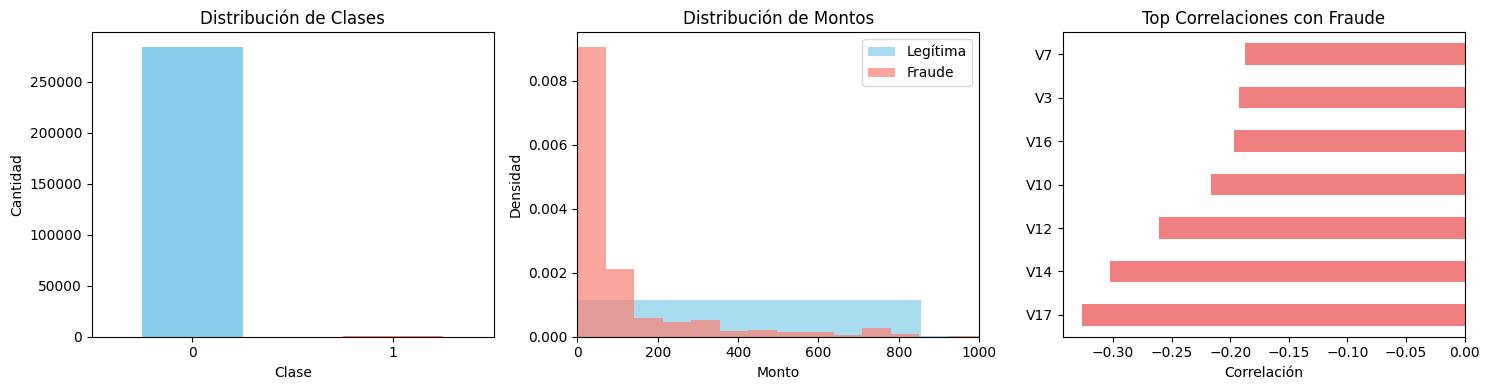


🔧 Preparando datos (muestra de 50,000 registros)...
📊 Muestra creada: 50,000 registros
   Fraudes: 492, Legítimas: 49,508
✅ División completada:
   Entrenamiento: 40,000 muestras
   Prueba: 10,000 muestras

🚀 Entrenamiento rápido de modelos...
⚡ LogisticRegression + Original... AUC: 0.9837 | AP: 0.8929
⚡ LogisticRegression + SMOTE_Fast... AUC: 0.9787 | AP: 0.8825
⚡ LogisticRegression + UnderSample... AUC: 0.9807 | AP: 0.8838
⚡ RandomForest_Fast + Original... AUC: 0.9705 | AP: 0.8784
⚡ RandomForest_Fast + SMOTE_Fast... AUC: 0.9788 | AP: 0.8831
⚡ RandomForest_Fast + UnderSample... AUC: 0.9768 | AP: 0.8756

🏆 Selección del mejor modelo:
------------------------------------------------------------
LogisticRegression_Original AUC: 0.9837 | AP: 0.8929
LogisticRegression_SMOTE_Fast AUC: 0.9787 | AP: 0.8825
LogisticRegression_UnderSample AUC: 0.9807 | AP: 0.8838
RandomForest_Fast_Original AUC: 0.9705 | AP: 0.8784
RandomForest_Fast_SMOTE_Fast AUC: 0.9788 | AP: 0.8831
RandomForest_Fast_UnderSam

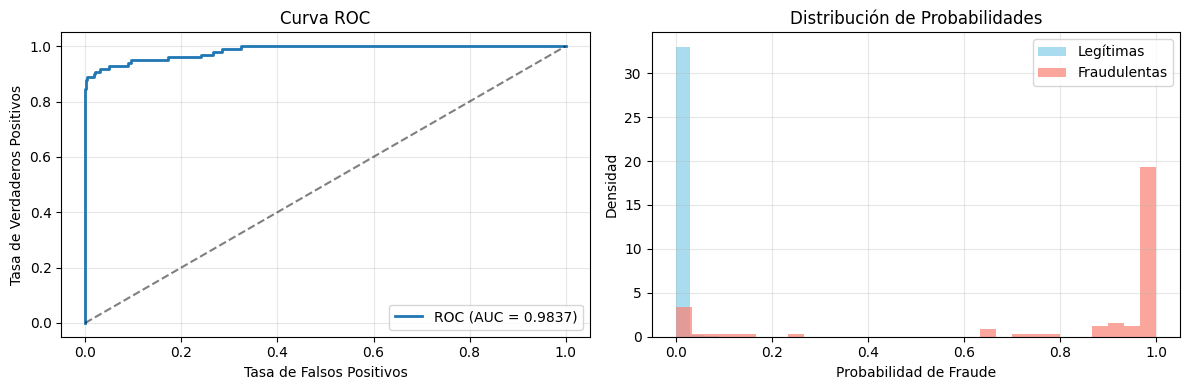


✅ ¡Pipeline completado!

💡 Ejemplo de uso para nuevas predicciones:
result = classifier.predict_transaction({
'V1': -2.0, 'V2': 1.5, ..., 'Amount': 100.0
})


In [8]:
# ============================================================
# EJECUCIÓN DEL PIPELINE
# ============================================================

classifier = run_fraud_detection_pipeline()

In [10]:
# ============================================================
# EJECUCIÓN DE UN EJEMPLO DE PREDICCIÓN INDIVIDUAL
# ============================================================

# Prueba el clasificador con una transacción sintética

mi_transaccion = {
    'V1': -1.359807, 'V2': -0.072781, 'V3': 2.536346, 'V4': 1.378155, 'V5': -0.338321,
    'V6': 0.462388, 'V7': 0.239599, 'V8': 0.098697, 'V9': 0.363787, 'V10': 0.090794,
    'V11': -0.551600, 'V12': -0.617801, 'V13': -0.991390, 'V14': -0.311169, 'V15': 1.468177,
    'V16': -0.470401, 'V17': 0.207971, 'V18': 0.025791, 'V19': 0.403993, 'V20': 0.251412,
    'V21': -0.018307, 'V22': 0.277838, 'V23': -0.110474, 'V24': 0.066928, 'V25': 0.128539,
    'V26': -0.189115, 'V27': 0.133558, 'V28': -0.021053, 'Amount': 149.62
}

# Realizar la predicción usando el clasificador entrenado
resultado = classifier.predict_transaction(mi_transaccion)
print("Resultado con input propio:", resultado)

Resultado con input propio: {'prediction': 'LEGÍTIMA ✅', 'probability': np.float64(0.25440371203098994), 'risk_level': 'BAJO'}


In [11]:
# ============================================================
# CLASE DE OPTIMIZACIÓN PARA REDUCCIÓN DE FALSOS NEGATIVOS
# ============================================================

class FalseNegativeOptimizer:
    """
    Optimizador específico para reducir falsos negativos en detección de fraude
    """

    def __init__(self, X_train, X_test, y_train, y_test):
        # Inicializa variables internas y el escalador
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.scaler = StandardScaler()
        self.results = {}

    def strategy_1_advanced_sampling(self):
        """
        Estrategia 1: Técnicas avanzadas de sampling
        """
        print("🔧 Estrategia 1: Técnicas Avanzadas de Sampling")
        print("-" * 50)

        # Define técnicas avanzadas de sampling
        sampling_techniques = {
            'BorderlineSMOTE': BorderlineSMOTE(random_state=33, k_neighbors=3),
            'ADASYN': ADASYN(random_state=33, n_neighbors=3),
            'SMOTETomek': SMOTETomek(random_state=33),
            'SMOTEENN': SMOTEENN(random_state=33),
            'SMOTE_Aggressive': SMOTE(random_state=33, k_neighbors=3, sampling_strategy=0.8)
        }

        for name, sampler in sampling_techniques.items():
            print(f"⚡ Probando {name}...", end=' ')

            # Escala la columna Amount
            self.scaler.fit(self.X_train[["Amount"]])
            X_train_scaled = self.X_train.copy()
            X_test_scaled = self.X_test.copy()
            X_train_scaled["Amount"] = self.scaler.transform(self.X_train[["Amount"]])
            X_test_scaled["Amount"] = self.scaler.transform(self.X_test[["Amount"]])

            # Aplica el sampling y entrena el modelo
            try:
                X_resampled, y_resampled = sampler.fit_resample(X_train_scaled, self.y_train)
                model = RandomForestClassifier(
                    n_estimators=100,
                    max_depth=12,
                    min_samples_split=5,
                    class_weight='balanced',
                    random_state=33,
                    n_jobs=-1
                )
                model.fit(X_resampled, y_resampled)
                y_pred = model.predict(X_test_scaled)
                y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
                cm = confusion_matrix(self.y_test, y_pred)
                tn, fp, fn, tp = cm.ravel()
                recall = tp / (tp + fn) if (tp + fn) > 0 else 0
                precision = tp / (tp + fp) if (tp + fp) > 0 else 0
                auc = roc_auc_score(self.y_test, y_pred_proba)
                # Guarda resultados para esta estrategia
                self.results[f"Strategy1_{name}"] = {
                    'model': model,
                    'scaler': self.scaler,
                    'feature_order': X_train_scaled.columns.tolist(),
                    'false_negatives': fn,
                    'false_positives': fp,
                    'recall': recall,
                    'precision': precision,
                    'auc': auc,
                    'predictions': y_pred,
                    'probabilities': y_pred_proba
                }
                print(f"FN: {fn}, FP: {fp}, Recall: {recall:.4f}, Precision: {precision:.4f}")
            except Exception as e:
                print(f"Error: {str(e)[:30]}...")

    def strategy_2_threshold_optimization(self):
        """
        Estrategia 2: Optimización del umbral de decisión
        """
        print("\n🎯 Estrategia 2: Optimización del Umbral")
        print("-" * 50)

        # Usa el mejor modelo de la estrategia 1 o entrena un modelo base
        if self.results:
            best_model_key = min(self.results.keys(), key=lambda x: self.results[x]['false_negatives'])
            best_model = self.results[best_model_key]['model']
            best_scaler = self.results[best_model_key]['scaler']
            feature_order = self.results[best_model_key]['feature_order']
            print(f"Usando modelo: {best_model_key}")
            X_test_scaled = self.X_test.copy()
            X_test_scaled["Amount"] = best_scaler.transform(self.X_test[["Amount"]])
            y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
        else:
            # Si no existe modelo previo, entrena uno rápido con SMOTE
            self.scaler.fit(self.X_train[["Amount"]])
            X_train_scaled = self.X_train.copy()
            X_test_scaled = self.X_test.copy()
            X_train_scaled["Amount"] = self.scaler.transform(self.X_train[["Amount"]])
            X_test_scaled["Amount"] = self.scaler.transform(self.X_test[["Amount"]])
            X_resampled, y_resampled = SMOTE(random_state=33).fit_resample(X_train_scaled, self.y_train)
            best_model = RandomForestClassifier(
                n_estimators=100,
                class_weight='balanced',
                random_state=33,
                n_jobs=-1
            )
            best_model.fit(X_resampled, y_resampled)
            best_scaler = self.scaler
            y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
            feature_order = X_train_scaled.columns.tolist()

        # Prueba distintos umbrales para minimizar FN
        thresholds = np.arange(0.1, 0.9, 0.05)
        threshold_results = []
        for threshold in thresholds:
            y_pred_thresh = (y_pred_proba >= threshold).astype(int)
            cm = confusion_matrix(self.y_test, y_pred_thresh)
            tn, fp, fn, tp = cm.ravel()
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            threshold_results.append({
                'threshold': threshold,
                'false_negatives': fn,
                'false_positives': fp,
                'recall': recall,
                'precision': precision,
                'f1': f1
            })

        # Selecciona el umbral con menos FN (y FP razonables)
        valid_thresholds = [r for r in threshold_results if r['false_positives'] <= 50]
        if valid_thresholds:
            optimal_threshold = min(valid_thresholds, key=lambda x: x['false_negatives'])
        else:
            optimal_threshold = min(threshold_results, key=lambda x: x['false_negatives'])

        print(f"🎯 Umbral óptimo: {optimal_threshold['threshold']:.3f}")
        print(f"   FN: {optimal_threshold['false_negatives']}")
        print(f"   FP: {optimal_threshold['false_positives']}")
        print(f"   Recall: {optimal_threshold['recall']:.4f}")
        print(f"   Precision: {optimal_threshold['precision']:.4f}")

        # Guarda el mejor resultado de umbral optimizado
        y_pred_optimal = (y_pred_proba >= optimal_threshold['threshold']).astype(int)
        self.results['Strategy2_OptimalThreshold'] = {
            'model': best_model,
            'scaler': best_scaler,
            'feature_order': feature_order,
            'threshold': optimal_threshold['threshold'],
            'false_negatives': optimal_threshold['false_negatives'],
            'false_positives': optimal_threshold['false_positives'],
            'recall': optimal_threshold['recall'],
            'precision': optimal_threshold['precision'],
            'predictions': y_pred_optimal,
            'probabilities': y_pred_proba
        }
        # Visualiza el análisis de umbrales
        self.plot_threshold_analysis(threshold_results)
        return optimal_threshold['threshold']

    def strategy_3_ensemble_voting(self):
        """
        Estrategia 3: Ensemble con votación conservadora
        """
        print("\n🤝 Estrategia 3: Ensemble Conservador")
        print("-" * 50)

        # Escala los datos para entrenamiento
        models = []
        self.scaler.fit(self.X_train[["Amount"]])
        X_train_scaled = self.X_train.copy()
        X_test_scaled = self.X_test.copy()
        X_train_scaled["Amount"] = self.scaler.transform(self.X_train[["Amount"]])
        X_test_scaled["Amount"] = self.scaler.transform(self.X_test[["Amount"]])

        # Modelo 1: Random Forest con alta sensibilidad
        X_smote, y_smote = SMOTE(random_state=33).fit_resample(X_train_scaled, self.y_train)
        model1 = RandomForestClassifier(
            n_estimators=150,
            max_depth=15,
            min_samples_split=3,
            min_samples_leaf=1,
            class_weight={0: 1, 1: 10},
            random_state=33,
            n_jobs=-1
        )
        model1.fit(X_smote, y_smote)
        models.append(('RF_HighSensitivity', model1))

        # Modelo 2: Random Forest con BorderlineSMOTE
        X_border, y_border = BorderlineSMOTE(random_state=33).fit_resample(X_train_scaled, self.y_train)
        model2 = RandomForestClassifier(
            n_estimators=100,
            max_depth=12,
            class_weight='balanced',
            random_state=34,
            n_jobs=-1
        )
        model2.fit(X_border, y_border)
        models.append(('RF_BorderlineSMOTE', model2))

        # Modelo 3: Random Forest con ADASYN
        try:
            X_adasyn, y_adasyn = ADASYN(random_state=33).fit_resample(X_train_scaled, self.y_train)
            model3 = RandomForestClassifier(
                n_estimators=100,
                max_depth=10,
                class_weight='balanced',
                random_state=35,
                n_jobs=-1
            )
            model3.fit(X_adasyn, y_adasyn)
            models.append(('RF_ADASYN', model3))
        except:
            print("   ADASYN falló, usando configuración alternativa")

        # Promedio de probabilidades de los modelos (ensemble)
        ensemble_probs = []
        for name, model in models:
            probs = model.predict_proba(X_test_scaled)[:, 1]
            ensemble_probs.append(probs)
        avg_probs = np.mean(ensemble_probs, axis=0)

        # Votación conservadora: umbral bajo para ser más sensible a fraudes
        conservative_threshold = 0.3
        y_pred_ensemble = (avg_probs >= conservative_threshold).astype(int)

        # Evalúa el ensemble y muestra métricas
        cm = confusion_matrix(self.y_test, y_pred_ensemble)
        tn, fp, fn, tp = cm.ravel()
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        auc = roc_auc_score(self.y_test, avg_probs)
        print(f"🎯 Ensemble Conservador:")
        print(f"   FN: {fn}, FP: {fp}")
        print(f"   Recall: {recall:.4f}, Precision: {precision:.4f}")
        print(f"   AUC: {auc:.4f}")

        # Guarda resultados del ensemble
        self.results['Strategy3_ConservativeEnsemble'] = {
            'models': models,
            'scaler': self.scaler,
            'feature_order': X_train_scaled.columns.tolist(),
            'threshold': conservative_threshold,
            'false_negatives': fn,
            'false_positives': fp,
            'recall': recall,
            'precision': precision,
            'auc': auc,
            'predictions': y_pred_ensemble,
            'probabilities': avg_probs
        }

    def strategy_4_cost_sensitive(self):
        """
        Estrategia 4: Aprendizaje sensible a costos
        """
        print("\n💰 Estrategia 4: Aprendizaje Sensible a Costos")
        print("-" * 50)

        # Prueba diferentes ratios de penalización para FN
        cost_ratios = [
            {0: 1, 1: 15},  # FN cuesta 15 veces más que FP
            {0: 1, 1: 20},  # FN cuesta 20 veces más que FP
            {0: 1, 1: 25},  # FN cuesta 25 veces más que FP
        ]
        self.scaler.fit(self.X_train[["Amount"]])
        X_train_scaled = self.X_train.copy()
        X_test_scaled = self.X_test.copy()
        X_train_scaled["Amount"] = self.scaler.transform(self.X_train[["Amount"]])
        X_test_scaled["Amount"] = self.scaler.transform(self.X_test[["Amount"]])
        X_smote, y_smote = SMOTE(random_state=33).fit_resample(X_train_scaled, self.y_train)

        # Entrena modelos con distintos costos
        for i, class_weight in enumerate(cost_ratios):
            model = RandomForestClassifier(
                n_estimators=100,
                max_depth=12,
                class_weight=class_weight,
                random_state=33,
                n_jobs=-1
            )
            model.fit(X_smote, y_smote)
            y_pred = model.predict(X_test_scaled)
            y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
            cm = confusion_matrix(self.y_test, y_pred)
            tn, fp, fn, tp = cm.ravel()
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            print(f"   Ratio {class_weight}: FN={fn}, FP={fp}, Recall={recall:.4f}, Precision={precision:.4f}")

            # Guarda resultados de cada ratio
            self.results[f'Strategy4_CostSensitive_{i+1}'] = {
                'model': model,
                'scaler': self.scaler,
                'feature_order': X_train_scaled.columns.tolist(),
                'false_negatives': fn,
                'false_positives': fp,
                'recall': recall,
                'precision': precision,
                'predictions': y_pred,
                'probabilities': y_pred_proba
            }

    def plot_threshold_analysis(self, threshold_results):
        """
        Visualiza el análisis de umbrales
        """
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        thresholds = [r['threshold'] for r in threshold_results]
        fn_counts = [r['false_negatives'] for r in threshold_results]
        fp_counts = [r['false_positives'] for r in threshold_results]
        recalls = [r['recall'] for r in threshold_results]
        precisions = [r['precision'] for r in threshold_results]
        # Gráfico de falsos negativos y positivos
        axes[0].plot(thresholds, fn_counts, 'r-', label='Falsos Negativos', linewidth=2)
        axes[0].plot(thresholds, fp_counts, 'b-', label='Falsos Positivos', linewidth=2)
        axes[0].set_xlabel('Umbral')
        axes[0].set_ylabel('Cantidad')
        axes[0].set_title('Falsos Negativos vs Falsos Positivos')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        # Gráfico de precisión vs recall
        axes[1].plot(thresholds, recalls, 'g-', label='Recall', linewidth=2)
        axes[1].plot(thresholds, precisions, 'orange', label='Precision', linewidth=2)
        axes[1].set_xlabel('Umbral')
        axes[1].set_ylabel('Métrica')
        axes[1].set_title('Precision vs Recall')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    def get_best_strategy(self):
        """
        Selecciona la mejor estrategia basada en FN mínimos
        """
        if not self.results:
            print("❌ No hay resultados para comparar")
            return None
        print("\n🏆 COMPARACIÓN DE ESTRATEGIAS")
        print("=" * 60)
        print(f"{'Estrategia':<30} {'FN':<4} {'FP':<4} {'Recall':<8} {'Precision':<8}")
        print("-" * 60)
        best_strategy = None
        min_fn = float('inf')
        for strategy_name, results in self.results.items():
            fn = results['false_negatives']
            fp = results['false_positives']
            recall = results['recall']
            precision = results['precision']
            print(f"{strategy_name:<30} {fn:<4} {fp:<4} {recall:<8.4f} {precision:<8.4f}")
            # Criterio: primero minimizar FN, luego minimizar FP
            if fn < min_fn or (fn == min_fn and fp < self.results[best_strategy]['false_positives'] if best_strategy else True):
                min_fn = fn
                best_strategy = strategy_name
        print("-" * 60)
        print(f"🎯 MEJOR ESTRATEGIA: {best_strategy}")
        print(f"   Falsos Negativos: {self.results[best_strategy]['false_negatives']}")
        print(f"   Falsos Positivos: {self.results[best_strategy]['false_positives']}")
        print(f"   Recall: {self.results[best_strategy]['recall']:.4f}")
        print(f"   Precision: {self.results[best_strategy]['precision']:.4f}")
        return best_strategy, self.results[best_strategy]


In [12]:
# ============================================================
# FUNCIÓN PRINCIPAL PARA EJECUTAR OPTIMIZACIÓN DE FALSOS NEGATIVOS
# ============================================================

def optimize_false_negatives(classifier):
    """
    Ejecuta todas las estrategias de optimización de falsos negativos
    """
    print("🔥 OPTIMIZACIÓN PARA REDUCIR FALSOS NEGATIVOS")
    print("=" * 50)

    # Extrae los conjuntos de entrenamiento y prueba del clasificador entrenado
    X_train = classifier.X_train
    X_test = classifier.X_test
    y_train = classifier.y_train
    y_test = classifier.y_test

    # Inicializa el optimizador de falsos negativos
    optimizer = FalseNegativeOptimizer(X_train, X_test, y_train, y_test)

    # Ejecuta todas las estrategias disponibles
    optimizer.strategy_1_advanced_sampling()     # Sampling avanzado
    optimizer.strategy_2_threshold_optimization()# Optimización de umbral
    optimizer.strategy_3_ensemble_voting()       # Ensemble conservador
    optimizer.strategy_4_cost_sensitive()        # Aprendizaje sensible a costos

    # Selecciona y retorna la mejor estrategia encontrada
    best_strategy, best_results = optimizer.get_best_strategy()

    return optimizer, best_strategy, best_results


🔥 OPTIMIZACIÓN PARA REDUCIR FALSOS NEGATIVOS
🔧 Estrategia 1: Técnicas Avanzadas de Sampling
--------------------------------------------------
⚡ Probando BorderlineSMOTE... FN: 16, FP: 8, Recall: 0.8367, Precision: 0.9111
⚡ Probando ADASYN... FN: 13, FP: 112, Recall: 0.8673, Precision: 0.4315
⚡ Probando SMOTETomek... FN: 15, FP: 14, Recall: 0.8469, Precision: 0.8557
⚡ Probando SMOTEENN... FN: 15, FP: 15, Recall: 0.8469, Precision: 0.8469
⚡ Probando SMOTE_Aggressive... FN: 15, FP: 11, Recall: 0.8469, Precision: 0.8830

🎯 Estrategia 2: Optimización del Umbral
--------------------------------------------------
Usando modelo: Strategy1_ADASYN
🎯 Umbral óptimo: 0.600
   FN: 15
   FP: 48
   Recall: 0.8469
   Precision: 0.6336


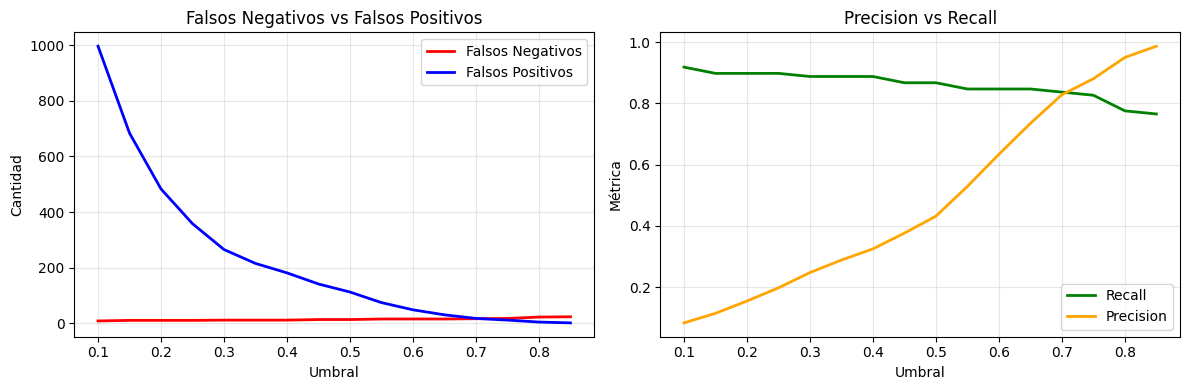


🤝 Estrategia 3: Ensemble Conservador
--------------------------------------------------
🎯 Ensemble Conservador:
   FN: 11, FP: 209
   Recall: 0.8878, Precision: 0.2939
   AUC: 0.9769

💰 Estrategia 4: Aprendizaje Sensible a Costos
--------------------------------------------------
   Ratio {0: 1, 1: 15}: FN=13, FP=238, Recall=0.8673, Precision=0.2632
   Ratio {0: 1, 1: 20}: FN=13, FP=318, Recall=0.8673, Precision=0.2109
   Ratio {0: 1, 1: 25}: FN=11, FP=398, Recall=0.8878, Precision=0.1794

🏆 COMPARACIÓN DE ESTRATEGIAS
Estrategia                     FN   FP   Recall   Precision
------------------------------------------------------------
Strategy1_BorderlineSMOTE      16   8    0.8367   0.9111  
Strategy1_ADASYN               13   112  0.8673   0.4315  
Strategy1_SMOTETomek           15   14   0.8469   0.8557  
Strategy1_SMOTEENN             15   15   0.8469   0.8469  
Strategy1_SMOTE_Aggressive     15   11   0.8469   0.8830  
Strategy2_OptimalThreshold     15   48   0.8469   0.6336  


In [14]:
# ============================================================
# EJECUTAR OPTIMIZACIÓN DE FALSOS NEGATIVOS Y GUARDAR RESULTADOS
# ============================================================

# Después de entrenar el clasificador principal, ejecuta la optimización:
optimizer, best_strategy, best_results = optimize_false_negatives(classifier)  # Ejecuta la función principal de optimización

# 'optimizer' contiene todos los resultados y estrategias probadas
# 'best_strategy' indica el nombre de la mejor estrategia encontrada
# 'best_results' incluye métricas clave (FN, FP, recall, precision, etc.) del mejor enfoque

# Puede revisar detalles así:
print("\nResultados de la mejor estrategia:")
print(best_results)

In [15]:
# ============================================================
# FUNCIÓN DE PREDICCIÓN INDIVIDUAL USANDO EL MODELO OPTIMIZADO
# ============================================================

def predict_transaction_optimizer(mi_transaccion, classifier, best_results, verbose=True):
    """
    Predice una transacción individual con el modelo optimizado.
    """

    import pandas as pd  # Importar pandas para manipulación de datos

    # Obtener el orden correcto de columnas desde los resultados del modelo optimizado
    feature_order = best_results['feature_order']
    df_trans = pd.DataFrame([mi_transaccion]).reindex(columns=feature_order, fill_value=0)

    # Escalar la columna 'Amount' utilizando el scaler del modelo optimizado
    scaler = best_results['scaler']
    if "Amount" in df_trans.columns:
        df_trans[["Amount"]] = scaler.transform(df_trans[["Amount"]])
    else:
        raise ValueError("La transacción debe incluir el campo 'Amount'.")

    # Obtener el modelo y el umbral óptimo
    model = best_results['model']
    prob = model.predict_proba(df_trans)[:, 1][0]  # Probabilidad de fraude
    threshold = best_results.get('threshold', 0.5)  # Usar umbral óptimo si existe, sino 0.5
    pred = int(prob >= threshold)

    # Determinar el nivel de riesgo en base a la probabilidad
    nivel = "ALTO" if prob > 0.7 else "MEDIO" if prob > 0.3 else "BAJO"
    resultado = {
        'prediction': 'FRAUDE ⚠️' if pred == 1 else 'LEGÍTIMA ✅',
        'probability': prob,
        'risk_level': nivel,
        'threshold_used': threshold
    }

    # Mostrar resultados si verbose=True
    if verbose:
        print(f"\n--- PREDICCIÓN TRANSACCIÓN INDIVIDUAL (Optimizada) ---")
        print(f"Probabilidad de fraude: {prob:.3f}")
        print(f"Umbral de decisión:     {threshold:.3f}")
        print(f"Nivel de riesgo:        {nivel}")
        print(f"Resultado:              {resultado['prediction']}\n")
    return resultado


In [16]:
# ============================================================
# EJECUCIÓN DE UNA PREDICCIÓN INDIVIDUAL CON MODELO OPTIMIZADO
# ============================================================

# Ejecutar la predicción para una transacción de ejemplo con el modelo optimizado
resultado = predict_transaction_optimizer(mi_transaccion, classifier, best_results)

# Mostrar el resultado de la predicción optimizada
print(resultado)


KeyError: 'model'

In [ ]:
# ============================================================
# EXPORTACIÓN DE MODELOS, ESCALADORES Y FEATURE_ORDER
# ============================================================

"""
Esta celda guarda:
  • El mejor modelo base y su escalador
  • El modelo optimizado y su escalador
  • El orden de columnas (feature_order) usado en cada uno
"""

# ───────────────────────────────────────────────
# ⚙️ Configuración de rutas
# ───────────────────────────────────────────────
MODELS_DIR         = Path("models")
BASE_MODEL_FILE    = MODELS_DIR / "best_base_model.pkl"
STRAT_MODEL_FILE   = MODELS_DIR / "best_strategy_model.pkl"
SCALER_FILE        = MODELS_DIR / "amount_scaler.pkl"
STRAT_SCALER_FILE  = MODELS_DIR / "strategy_scaler.pkl"
BASE_FEATORDER_FILE  = MODELS_DIR / "base_feature_order.pkl"
STRAT_FEATORDER_FILE = MODELS_DIR / "strategy_feature_order.pkl"

MODELS_DIR.mkdir(exist_ok=True)

# ───────────────────────────────────────────────
# 📦 Recuperar mejor modelo base, optimizado y feature_order
# ───────────────────────────────────────────────
try:
    # Mejor modelo base y escalador
    best_base_model   = classifier.best_model['model']
    base_scaler       = classifier.best_model['scaler']
    base_feature_order = classifier.best_model.get('feature_order')

    # Mejor modelo de estrategia y escalador
    best_strategy_model   = optimizer.results[best_strategy]['model']
    strategy_scaler       = optimizer.results[best_strategy]['scaler']
    strategy_feature_order = optimizer.results[best_strategy]['feature_order']

    # ───────────────────────────────────────────
    # 💾 Guardar los artefactos
    # ───────────────────────────────────────────
    joblib.dump(best_base_model,      BASE_MODEL_FILE)
    joblib.dump(best_strategy_model,  STRAT_MODEL_FILE)
    joblib.dump(base_scaler,          SCALER_FILE)
    joblib.dump(strategy_scaler,      STRAT_SCALER_FILE)
    joblib.dump(base_feature_order,   BASE_FEATORDER_FILE)
    joblib.dump(strategy_feature_order, STRAT_FEATORDER_FILE)

    print("\n✅ Modelos, escaladores y orden de columnas guardados exitosamente.")
    print("------------------------------------------------------")
    print(f"📂 Carpeta de exportación: {MODELS_DIR.resolve()}\n")
    print("Archivos exportados:")
    print(f"   • Modelo base:            {BASE_MODEL_FILE.name}")
    print(f"   • Escalador base:         {SCALER_FILE.name}")
    print(f"   • Orden columnas base:    {BASE_FEATORDER_FILE.name}")
    print(f"   • Modelo optimizado:      {STRAT_MODEL_FILE.name}")
    print(f"   • Escalador optimizado:   {STRAT_SCALER_FILE.name}")
    print(f"   • Orden columnas opt.:    {STRAT_FEATORDER_FILE.name}\n")
    print("------------------------------------------------------")
    print("ℹ️  ¿Cómo reutilizar estos artefactos en producción?")
    print("  1. Usa joblib.load('ruta/al/archivo.pkl') para cargar cada objeto.")
    print("  2. Antes de predecir, reordena el DataFrame: df = df[feature_order]")
    print("  3. Escala únicamente la columna 'Amount' usando el escalador correspondiente.")
    print("  4. Aplica el threshold óptimo si usas el modelo optimizado.\n")
    print("👉 Estos archivos son indispensables para desplegar el modelo en una app o API y asegurar la robustez en producción.")
    print("------------------------------------------------------")

except AttributeError as e:
    print("⚠️ Error: asegúrate de que `classifier` y `optimizer` han sido ejecutados correctamente")
    print(f"🔴 Detalle: {e}")



✅ Modelos, escaladores y orden de columnas guardados exitosamente.
------------------------------------------------------
📂 Carpeta de exportación: /content/models

Archivos exportados:
   • Modelo base:            best_base_model.pkl
   • Escalador base:         amount_scaler.pkl
   • Orden columnas base:    base_feature_order.pkl
   • Modelo optimizado:      best_strategy_model.pkl
   • Escalador optimizado:   strategy_scaler.pkl
   • Orden columnas opt.:    strategy_feature_order.pkl

------------------------------------------------------
ℹ️  ¿Cómo reutilizar estos artefactos en producción?
  1. Usa joblib.load('ruta/al/archivo.pkl') para cargar cada objeto.
  2. Antes de predecir, reordena el DataFrame: df = df[feature_order]
  3. Escala únicamente la columna 'Amount' usando el escalador correspondiente.
  4. Aplica el threshold óptimo si usas el modelo optimizado.

👉 Estos archivos son indispensables para desplegar el modelo en una app o API y asegurar la robustez en producción.


In [ ]:
# ============================================================
# GENERACIÓN Y EXPORTACIÓN DE ESTADÍSTICAS DE VARIABLES POR CLASE
# ============================================================

# ───────────────────────────────────────────────
# 🚦 Configuración: columnas a usar
# ───────────────────────────────────────────────
# Elimina 'Time' (no útil) y asegura el orden estándar de features
feature_cols = [col for col in df_model.columns if col.startswith("V")] + ["Amount"]
target_col = "Class"

# Si hay columnas extra, como IDs, exclúyelas aquí si lo necesitas:
# feature_cols = [col for col in feature_cols if col not in ("ID", ...)]

# ───────────────────────────────────────────────
# 🧬 Calcular estadísticas por clase
# ───────────────────────────────────────────────
synth_stats = {}

for cls in [0, 1]:
    df_cls = df_model[df_model[target_col] == cls]
    X_cls = df_cls[feature_cols].astype(float)
    synth_stats[cls] = {
        "mean": X_cls.mean(axis=0).values,  # array de medias en el mismo orden
        "cov":  X_cls.cov().values          # matriz de covarianza
    }

# ───────────────────────────────────────────────
# 💾 Guardar el artefacto en 'models/synth_stats.pkl'
# ───────────────────────────────────────────────
models_dir = Path("models")
models_dir.mkdir(exist_ok=True)
joblib.dump(
    {
        "stats": synth_stats,
        "feature_order": feature_cols
    },
    models_dir / "synth_stats.pkl"
)

# ───────────────────────────────────────────────
print("✅ synth_stats.pkl generado exitosamente.")
print(f"   Contiene estadísticas para variables: {feature_cols}")
print(f"   Carpeta de salida: {models_dir.resolve()}\n")
print("ℹ️ Utiliza este artefacto para generar transacciones sintéticas compatibles con tus modelos de predicción.")
print("   • El orden de las columnas (feature_order) es clave para la generación y para la predicción.")
print("   • Puedes cargarlo con joblib.load() y generar muestras con numpy.random.multivariate_normal()")


✅ synth_stats.pkl generado exitosamente.
   Contiene estadísticas para variables: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
   Carpeta de salida: /content/models

ℹ️ Utiliza este artefacto para generar transacciones sintéticas compatibles con tus modelos de predicción.
   • El orden de las columnas (feature_order) es clave para la generación y para la predicción.
   • Puedes cargarlo con joblib.load() y generar muestras con numpy.random.multivariate_normal()


In [19]:
# ============================================================
# FUNCIÓN DE PREDICCIÓN INDIVIDUAL USANDO EL MODELO OPTIMIZADO
# ============================================================

def predict_transaction_optimizer(mi_transaccion, classifier, best_results, verbose=True):
    """
    Predice una transacción individual con el modelo optimizado.
    """

    import pandas as pd  # Importar pandas para manipulación de datos
    import numpy as np # Import numpy for probability averaging

    # Obtener el order correcto de columnas desde los resultados del modelo optimizado
    feature_order = best_results['feature_order']
    df_trans = pd.DataFrame([mi_transaccion]).reindex(columns=feature_order, fill_value=0)

    # Escalar la columna 'Amount' utilizando el scaler del modelo optimizado
    scaler = best_results['scaler']
    if "Amount" in df_trans.columns:
        df_trans[["Amount"]] = scaler.transform(df_trans[["Amount"]])
    else:
        raise ValueError("La transacción debe incluir el campo 'Amount'.")

    # Obtener el modelo(s) y el umbral óptimo
    if 'model' in best_results:
        # Case for a single model
        model = best_results['model']
        prob = model.predict_proba(df_trans)[:, 1][0]  # Probabilidad de fraude
    elif 'models' in best_results:
        # Case for an ensemble of models
        ensemble_probs = []
        for name, model in best_results['models']:
            probs = model.predict_proba(df_trans)[:, 1][0]
            ensemble_probs.append(probs)
        prob = np.mean(ensemble_probs) # Average probabilities
    else:
        raise ValueError("best_results must contain either 'model' or 'models' key.")


    threshold = best_results.get('threshold', 0.5)  # Usar umbral óptimo si existe, sino 0.5
    pred = int(prob >= threshold)

    # Determinar el nivel de riesgo en base a la probabilidad
    nivel = "ALTO" if prob > 0.7 else "MEDIO" if prob > 0.3 else "BAJO"
    resultado = {
        'prediction': 'FRAUDE ⚠️' if pred == 1 else 'LEGÍTIMA ✅',
        'probability': prob,
        'risk_level': nivel,
        'threshold_used': threshold
    }

    # Mostrar resultados si verbose=True
    if verbose:
        print(f"\n--- PREDICCIÓN TRANSACCIÓN INDIVIDUAL (Optimizada) ---")
        print(f"Probabilidad de fraude: {prob:.3f}")
        print(f"Umbral de decisión:     {threshold:.3f}")
        print(f"Nivel de riesgo:        {nivel}")
        print(f"Resultado:              {resultado['prediction']}\n")
    return resultado

In [20]:
# ============================================================
# EJECUCIÓN DE UNA PREDICCIÓN INDIVIDUAL CON MODELO OPTIMIZADO
# ============================================================

# Ejecutar la predicción para una transacción de ejemplo con el modelo optimizado
resultado = predict_transaction_optimizer(mi_transaccion, classifier, best_results)

# Mostrar el resultado de la predicción optimizada
print(resultado)


--- PREDICCIÓN TRANSACCIÓN INDIVIDUAL (Optimizada) ---
Probabilidad de fraude: 0.077
Umbral de decisión:     0.300
Nivel de riesgo:        BAJO
Resultado:              LEGÍTIMA ✅

{'prediction': 'LEGÍTIMA ✅', 'probability': np.float64(0.07717853327316919), 'risk_level': 'BAJO', 'threshold_used': 0.3}


In [22]:
# ============================================================
# 📦 EXPORTACIÓN DE MODELOS, ESCALADORES Y FEATURE_ORDER
# ============================================================
"""
Esta celda guarda:
  • El mejor modelo base y su escalador
  • El modelo optimizado y su escalador
  • El orden de columnas (feature_order) usado en cada uno
"""

# ──────────────────────────────
# ⚙️ Configuración de rutas para guardar artefactos
# ──────────────────────────────
MODELS_DIR         = Path("models")
BASE_MODEL_FILE    = MODELS_DIR / "best_base_model.pkl"
STRAT_MODEL_FILE   = MODELS_DIR / "best_strategy_model.pkl"
SCALER_FILE        = MODELS_DIR / "amount_scaler.pkl"
STRAT_SCALER_FILE  = MODELS_DIR / "strategy_scaler.pkl"
BASE_FEATORDER_FILE  = MODELS_DIR / "base_feature_order.pkl"
STRAT_FEATORDER_FILE = MODELS_DIR / "strategy_feature_order.pkl"

MODELS_DIR.mkdir(exist_ok=True)

# ──────────────────────────────
# 📦 Recuperar y guardar modelos y configuraciones
# ──────────────────────────────
try:
    # Extraer mejor modelo base y escalador
    best_base_model      = classifier.best_model['model']
    base_scaler          = classifier.best_model['scaler']
    base_feature_order   = classifier.best_model.get('feature_order')

    # Extraer mejor modelo de estrategia y escalador optimizado
    best_strategy_results = optimizer.results[best_strategy]
    if 'model' in best_strategy_results:
        best_strategy_model = best_strategy_results['model']
    elif 'models' in best_strategy_results:
        # If it's an ensemble, save the list of models
        best_strategy_model = best_strategy_results['models']
    else:
        raise ValueError("Best strategy results do not contain 'model' or 'models' key.")

    strategy_scaler          = best_strategy_results['scaler']
    strategy_feature_order   = best_strategy_results['feature_order']


    # Guardar los artefactos entrenados en disco
    joblib.dump(best_base_model,      BASE_MODEL_FILE)
    joblib.dump(best_strategy_model,  STRAT_MODEL_FILE)
    joblib.dump(base_scaler,          SCALER_FILE)
    joblib.dump(strategy_scaler,      STRAT_SCALER_FILE)
    joblib.dump(base_feature_order,   BASE_FEATORDER_FILE)
    joblib.dump(strategy_feature_order, STRAT_FEATORDER_FILE)

    print("\n✅ Modelos, escaladores y orden de columnas guardados exitosamente.")
    print("------------------------------------------------------")
    print(f"📂 Carpeta de exportación: {MODELS_DIR.resolve()}\n")
    print("Archivos exportados:")
    print(f"   • Modelo base:            {BASE_MODEL_FILE.name}")
    print(f"   • Escalador base:         {SCALER_FILE.name}")
    print(f"   • Orden columnas base:    {BASE_FEATORDER_FILE.name}")
    print(f"   • Modelo optimizado:      {STRAT_MODEL_FILE.name}")
    print(f"   • Escalador optimizado:   {STRAT_SCALER_FILE.name}")
    print(f"   • Orden columnas opt.:    {STRAT_FEATORDER_FILE.name}\n")
    print("------------------------------------------------------")
    print("ℹ️  ¿Cómo reutilizar estos artefactos en producción?")
    print("  1. Usa joblib.load('ruta/al/archivo.pkl') para cargar cada objeto.")
    print("  2. Antes de predecir, reordena el DataFrame: df = df[feature_order]")
    print("  3. Escala únicamente la columna 'Amount' usando el escalador correspondiente.")
    print("  4. Aplica el threshold óptimo si usas el modelo optimizado.\n")
    print("👉 Estos archivos son indispensables para desplegar el modelo en una app o API y asegurar la robustez en producción.")
    print("------------------------------------------------------")

except AttributeError as e:
    print("⚠️ Error: asegúrate de que `classifier` y `optimizer` han sido ejecutados correctamente")
    print(f"🔴 Detalle: {e}")
except KeyError as e:
    print(f"⚠️ Error: Falta la clave esperada en los resultados del modelo: {e}")
except ValueError as e:
    print(f"⚠️ Error: {e}")


✅ Modelos, escaladores y orden de columnas guardados exitosamente.
------------------------------------------------------
📂 Carpeta de exportación: /content/models

Archivos exportados:
   • Modelo base:            best_base_model.pkl
   • Escalador base:         amount_scaler.pkl
   • Orden columnas base:    base_feature_order.pkl
   • Modelo optimizado:      best_strategy_model.pkl
   • Escalador optimizado:   strategy_scaler.pkl
   • Orden columnas opt.:    strategy_feature_order.pkl

------------------------------------------------------
ℹ️  ¿Cómo reutilizar estos artefactos en producción?
  1. Usa joblib.load('ruta/al/archivo.pkl') para cargar cada objeto.
  2. Antes de predecir, reordena el DataFrame: df = df[feature_order]
  3. Escala únicamente la columna 'Amount' usando el escalador correspondiente.
  4. Aplica el threshold óptimo si usas el modelo optimizado.

👉 Estos archivos son indispensables para desplegar el modelo en una app o API y asegurar la robustez en producción.


In [23]:
# ============================================================
# 📊 GENERACIÓN Y EXPORTACIÓN DE ESTADÍSTICAS DE VARIABLES POR CLASE
# ============================================================
"""
Esta celda calcula y guarda:
  • Las medias y matrices de covarianza para cada clase (legítima/fraude)
  • El orden de las features empleadas
  • Un artefacto 'synth_stats.pkl' reutilizable para generación sintética
"""

import joblib
from pathlib import Path

# ──────────────────────────────
# 🚦 Seleccionar y ordenar columnas relevantes
# ──────────────────────────────
# Selecciona solo variables V1-V28 + Amount, excluyendo 'Time'
feature_cols = [col for col in df_model.columns if col.startswith("V")] + ["Amount"]
target_col = "Class"

# Si existen columnas irrelevantes (IDs, etc.), puedes excluirlas aquí si es necesario:
# feature_cols = [col for col in feature_cols if col not in ("ID", ...)]

# ──────────────────────────────
# 🧬 Calcular medias y covarianzas por clase
# ──────────────────────────────
synth_stats = {}

for cls in [0, 1]:
    # Filtrar por clase (0: legítima, 1: fraude)
    df_cls = df_model[df_model[target_col] == cls]
    X_cls = df_cls[feature_cols].astype(float)
    synth_stats[cls] = {
        "mean": X_cls.mean(axis=0).values,  # Media de cada variable
        "cov":  X_cls.cov().values          # Covarianza entre variables
    }

# ──────────────────────────────
# 💾 Guardar artefacto para uso posterior
# ──────────────────────────────
models_dir = Path("models")
models_dir.mkdir(exist_ok=True)
joblib.dump(
    {
        "stats": synth_stats,
        "feature_order": feature_cols
    },
    models_dir / "synth_stats.pkl"
)

# ──────────────────────────────
# ✅ Mensaje de éxito e instrucciones de uso
# ──────────────────────────────
print("✅ synth_stats.pkl generado exitosamente.")
print(f"   Contiene estadísticas para variables: {feature_cols}")
print(f"   Carpeta de salida: {models_dir.resolve()}\n")
print("ℹ️ Utiliza este artefacto para generar transacciones sintéticas compatibles con tus modelos de predicción.")
print("   • El orden de las columnas (feature_order) es clave para la generación y para la predicción.")
print("   • Puedes cargarlo con joblib.load() y generar muestras con numpy.random.multivariate_normal()")


✅ synth_stats.pkl generado exitosamente.
   Contiene estadísticas para variables: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
   Carpeta de salida: /content/models

ℹ️ Utiliza este artefacto para generar transacciones sintéticas compatibles con tus modelos de predicción.
   • El orden de las columnas (feature_order) es clave para la generación y para la predicción.
   • Puedes cargarlo con joblib.load() y generar muestras con numpy.random.multivariate_normal()
